In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.gpt2_generation import GPT2GenerationAnonymization
from models.gpt2_model import PretrainedGPT2TextInfilling
from mask.personal_entity import MaskEntityType

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)
anon_gpt2_config = yaml.load(open("configs/gpt2_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на обезличенном датасете i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на обезличенном с помощью GPT2 датасете i2b2 2014 без учёта регистра

### Этап 3: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [7]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
model_reader = TensorBoardReader(Path(anon_gpt2_config["log_dir"]) / Path("lightning_logs"))
path_to_checkpoint = model_reader.get_ckpt_path(anon_gpt2_config["model_version"])
text_infill_model = PretrainedGPT2TextInfilling.load_from_checkpoint(path_to_checkpoint).to("cuda:0")

anonymization = GPT2GenerationAnonymization(text_infill_model, 
                                            label2type=lambda x: MaskEntityType[x.upper()], 
                                            mask_types=list(MaskEntityType), **anon_gpt2_config)

In [8]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization, device='cpu',
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Start data tokenization


100%|██████████| 181/181 [04:45<00:00,  1.58s/it]
Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [11]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(6))

In [12]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9876446723937988
     test_precision         0.9876446723937988
       test_recall          0.8199714422225952
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.8199714422225952,
  'test_precision': 0.9876446723937988,
  'test_f1': 0.9876446723937988}]

              precision    recall  f1-score   support

        NAME     0.8154    0.7788    0.7967     12084
  PROFESSION     0.7961    0.7074    0.7491       458
    LOCATION     0.7839    0.3866    0.5178      6089
         AGE     0.8822    0.7745    0.8249      1131
        DATE     0.8454    0.9799    0.9077     32232
          ID     0.6556    0.5255    0.5834      4065
     CONTACT     0.4743    0.3051    0.3713      1393

   micro avg     0.8199    0.8200    0.8199     57452
   macro avg     0.7504    0.6368    0.6787     57452
weighted avg     0.8105    0.8200    0.8042     57452



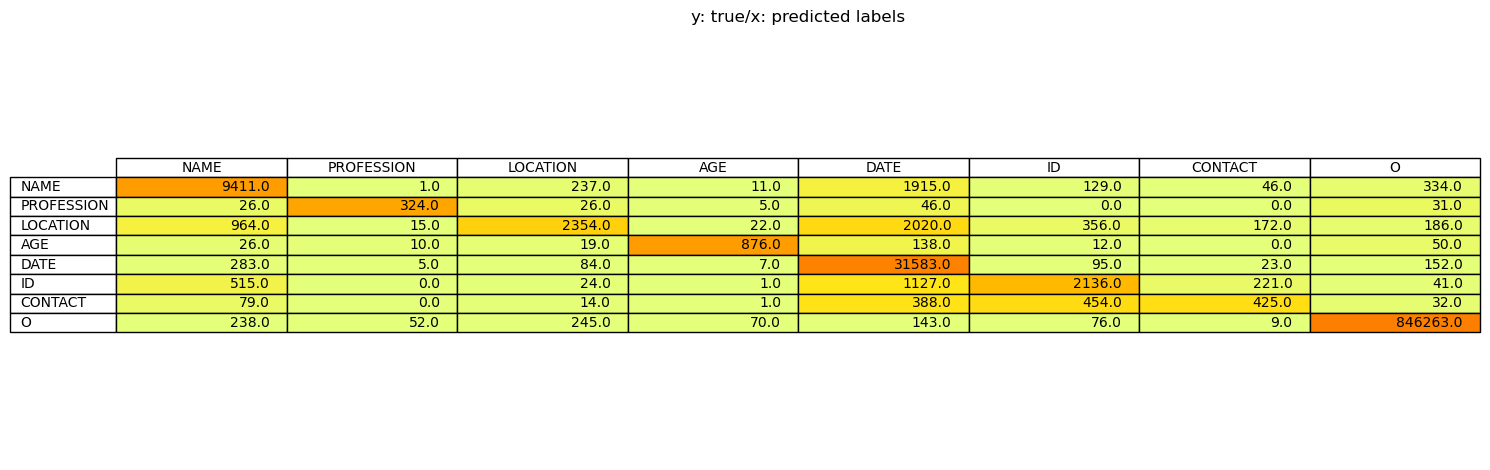

Wrongly predicted examples:
_____ Record 349-04:-11 _____
| Sentence:    | record | date | : | 2078 | -    | 03   | -    | 14   | nathan | comes | in | for | f | / | u | , | accomapanied | by | her | daughter | . | she | was | admitted | to | nathan   | '        | s        | clinic   | in | january | for | inability | to | walk | secondary | to | r | leg | weakness | ; | transferred | to | nathan   | '        | s        | clinic   | in | january  | on | 3    | /    | 14   | till | 3    | /    | . | she | loved | it | there | . | she | had | emg | while | there | which | revealed | r | femoral | neuropaty | , | with | 6 | mo | rpt | test | recommended | . | she | wears | a | brace | most | of | the | time | , | and |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME   | O     | O  | O   | O | O | O | O | O            | O  | O   | O        | O | O   | O   | O        | O  | LOCATION | LOCATION | LOCATION | LOCATION | O  | DATE    | O   | O         | O  | O    | 

In [13]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [14]:
stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 373-04:-9 _____
| Sentence:    | - | urobi | trace | , | ua | - | nit | positive | , | ua | - | wbc | 3 | + | , | mic | - | sed | completed | , | hcast | none | , | uas | - | rbc | packed | , | uas | - | wbc | 20 | - | 50 | 02   | /    | 15   | /    | 2077 | uas | - | bact | negative | , | uas | - | sqhi | negative | 02   | /    | 15   | /    | 2077 | 21 | : | 55 | 2        | /        | 15       | /        | 2077     | radiologystudy | name | chest | 2 | viewsaccession | # | 727 | -  | 8  | -  | 23 | -  | 7  | status |
| True labels: | O | O     | O     | O | O  | O | O   | O        | O | O  | O | O   | O | O | O | O   | O | O   | O         | O | O     | O    | O | O   | O | O   | O      | O | O   | O | O   | O  | O | O  | DATE | DATE | DATE | DATE | DATE | O   | O | O    | O        | O | O   | O | O    | O        | DATE | DATE | DATE | DATE | DATE | O  | O | O  | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | O              | O    | O  

In [25]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 191-02:-49 _____
| Sentence:    | record | date | : | 2094 | -    | 03   | -    | 19   | gsh      | internal | medicine | admit | note | patient | ' | s | name | : | faulkner | ,    | yandel | mrn | : | 507 | -  | 55 | -  | 61 | date | of | admission | : | 3    | /    | 18   | /    | 94   | attg | : | yazzie | contact | : | carlos | faulkner | ( | son | ) | 441     | -       | 626     | -       | 7981    | ; | 278     | -       | 032     | -       | 7163    | id | / | cc | : | 69  | yo | m | with | complicated | medical | history | presents | from | rehab | with | likely | aspiration | event | . | most | of | the | data | herein | is |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | O        | O        | O     | O    | O       | O | O | O    | O | NAME     | NAME | NAME   | O   | O | ID  | ID | ID | ID | ID | O    | O  | O         | O | DATE | DATE | DATE | DATE | DATE | O    | O | NAME   | O       | O | NAME  

['112-02:-12',
 '114-04:-33',
 '115-04:-22',
 '115-04:-30',
 '115-04:-31',
 '115-04:-8',
 '115-04:-9',
 '118-02:-2',
 '130-04:-33',
 '130-04:-34',
 '132-03:-8',
 '137-01:-17',
 '137-02:-15',
 '138-01:-10',
 '138-02:-9',
 '138-03:-13',
 '138-04:-17',
 '163-02:-9',
 '164-03:-8',
 '166-01:-1',
 '166-01:0',
 '167-04:-20',
 '169-03:0',
 '191-02:-48',
 '191-02:-49',
 '198-02:-2',
 '198-02:-3',
 '199-01:-12',
 '201-02:-34',
 '201-02:-35',
 '201-04:-44',
 '201-05:-1',
 '204-01:-8',
 '204-01:-9',
 '207-01:-1',
 '207-01:-20',
 '207-01:-21',
 '210-04:-22',
 '210-04:-33',
 '210-04:-4',
 '210-04:-5',
 '215-05:-2',
 '216-04:-71',
 '216-04:-72',
 '216-05:-11',
 '216-05:-12',
 '218-01:0',
 '218-05:-27',
 '218-05:-28',
 '231-01:-1',
 '232-03:-3',
 '232-04:-26',
 '232-04:-27',
 '232-04:-28',
 '232-04:-48',
 '232-04:-49',
 '262-04:-19',
 '314-01:-18',
 '314-02:-18',
 '315-04:-1',
 '317-04:-4',
 '318-01:-11',
 '318-03:-11',
 '318-04:-9',
 '319-05:-1',
 '319-05:0',
 '340-02:-15',
 '340-03:-16',
 '341-03:-3

**Вывод:**  
В целом все метки предсказываются с точностью, близко к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 4: Обучение модели на анонимизированных данных

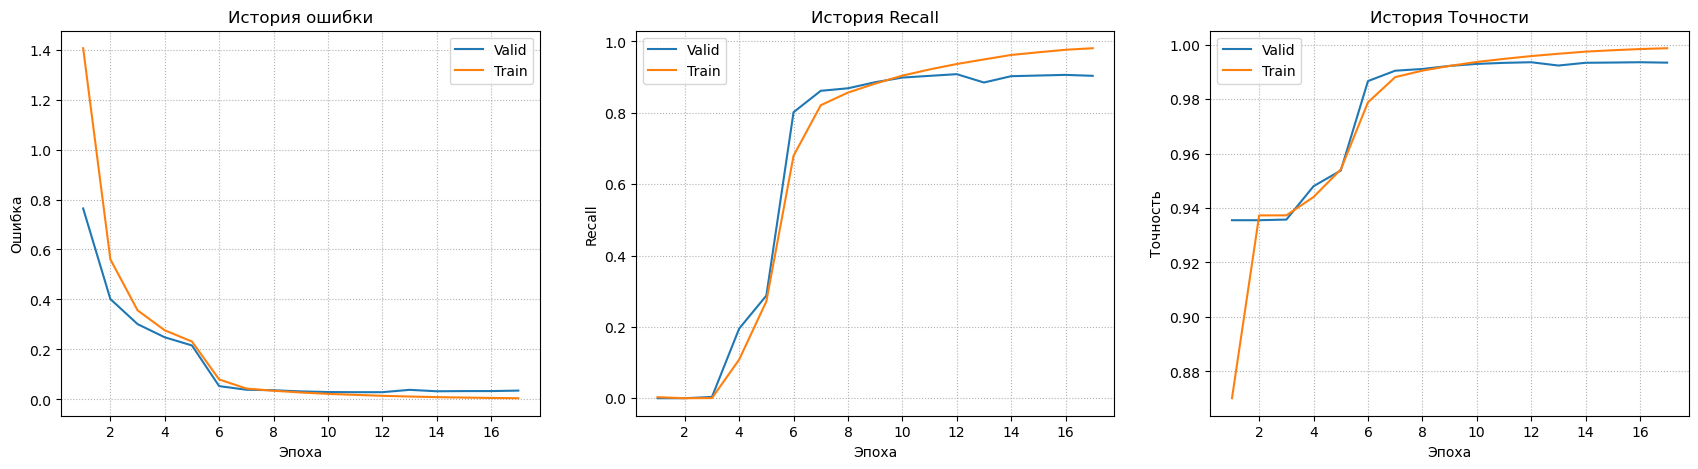

In [15]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(10)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [16]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"], device='cpu', **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [17]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(10)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [18]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9935759902000427
     test_precision         0.9935759902000427
       test_recall           0.908319354057312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.908319354057312,
  'test_precision': 0.9935759902000427,
  'test_f1': 0.9935759902000427}]

              precision    recall  f1-score   support

        NAME     0.9729    0.9021    0.9362     11741
  PROFESSION     0.9717    0.6814    0.8011       656
    LOCATION     0.8074    0.7339    0.7689      6211
         AGE     0.9206    0.9362    0.9283      1300
        DATE     0.9916    0.9746    0.9830     32754
          ID     0.8895    0.8049    0.8451      4510
     CONTACT     0.8570    0.5661    0.6818      1270

   micro avg     0.9578    0.9083    0.9324     58442
   macro avg     0.9158    0.7999    0.8492     58442
weighted avg     0.9557    0.9083    0.9304     58442



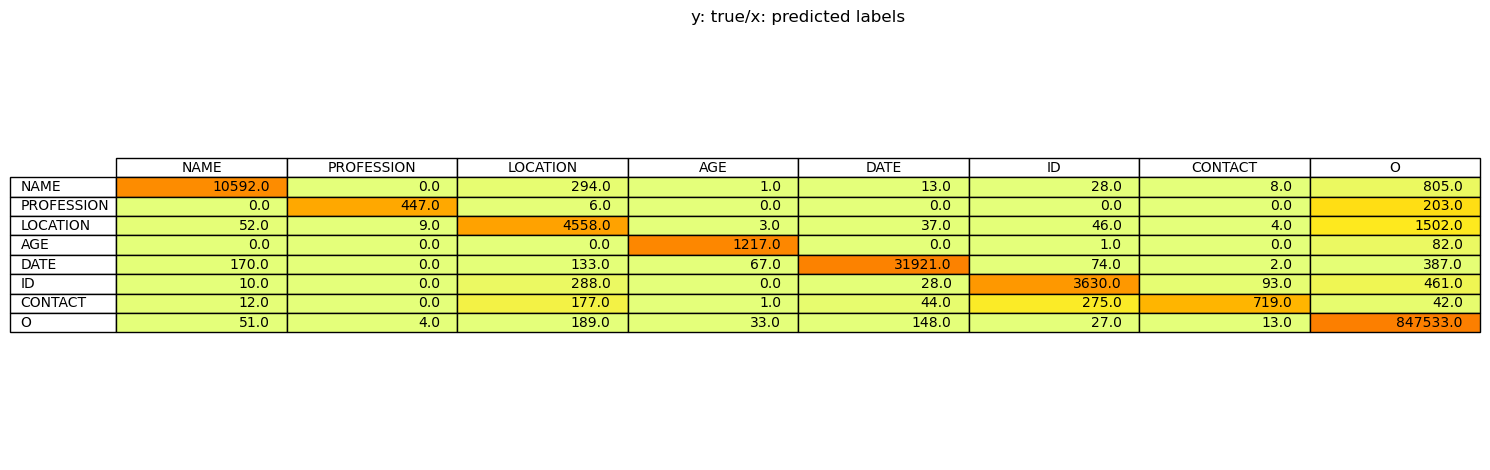

Wrongly predicted examples:
_____ Record 131-01:-26 _____
| Sentence:    | record | date | : | 2091 | -    | 07   | -    | 11   | reason | for | visit | comprehensive | evaluation | of | all | problems | . | problems | hypertension | present | since | mid  | 2060 | '    | s    | . | followed | by | dr | . | thacker | at | dardanelle | hospital | . | ett | 5    | /    | 12   | /    | 82   | to | 98 | % | prmhr | showed | st | changes | which | were | suggestive | but | not | diagnostic | and | there | was | baseline | lvh | with | strain | but | thallium | was | neg | . | there | were | occasional | pvc | ' | s | and | couplets | and | two | 3 | beat | runs | of | vt | . | had |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O      | O   | O     | O             | O          | O  | O   | O        | O | O        | O            | O       | O     | O    | DATE | DATE | DATE | O | O        | O  | O  | O | NAME    | O  | LOCATION   | LOCATION | O | O   | DATE | DATE |

In [19]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

In [23]:
stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 372-03:-14 _____
| Sentence:    | alone | . | he | never | married | and | has | no | children | . | he | is | a | retired | heavy      | -          | duty       | equipment  | mechanic   | ( | 15yrs | ) | and | concrete   | finisher   | ( | 25yrs | ) | . | he | is | a | veteran    | . | the | patient | quit | smoking | 20 | years | ago | but | had | smoked | 1 | . | 5ppd | * | 20yrs | ( | 30 | pack | year | ) | . | very | rarely | drinks | . | physical | examination | blood | pressure | 135 | / | 70 | pulse | 82 | respiratory | rate | 12 | general | appearance | nad | , | pleasant | . | in | a | wheelchair | skin | abcess | under | left | axilla | has | healed | well | . |
| True labels: | O     | O | O  | O     | O       | O   | O   | O  | O        | O | O  | O  | O | O       | PROFESSION | PROFESSION | PROFESSION | PROFESSION | PROFESSION | O | O     | O | O   | PROFESSION | PROFESSION | O | O     | O | O | O  | O  | O | PROFESSION | O | O   

['114-04:-22',
 '114-04:-23',
 '130-02:-20',
 '130-02:-21',
 '130-04:-16',
 '131-01:-4',
 '131-01:-5',
 '131-02:-7',
 '131-03:-19',
 '131-03:-20',
 '131-04:-15',
 '131-04:-16',
 '134-01:-4',
 '134-01:-5',
 '161-01:-16',
 '161-05:-11',
 '163-01:-7',
 '163-01:-8',
 '163-03:-8',
 '163-03:-9',
 '166-03:-18',
 '193-01:-6',
 '193-02:-7',
 '193-05:-34',
 '194-02:-26',
 '194-02:-27',
 '194-03:-21',
 '194-03:-22',
 '200-01:-12',
 '201-01:-21',
 '201-01:-22',
 '201-04:-18',
 '202-03:-12',
 '202-03:-13',
 '204-04:-10',
 '204-04:-9',
 '207-01:-15',
 '207-01:-16',
 '211-02:-17',
 '215-03:-15',
 '215-03:-16',
 '217-01:-6',
 '217-03:-13',
 '217-03:-14',
 '219-01:-5',
 '219-01:-6',
 '231-01:-8',
 '231-01:-9',
 '231-02:-13',
 '231-03:-4',
 '231-03:-5',
 '231-04:-7',
 '231-04:-8',
 '231-05:-12',
 '231-05:-5',
 '235-03:-3',
 '235-03:-4',
 '236-01:-13',
 '237-03:-7',
 '237-03:-8',
 '237-04:-14',
 '237-04:-15',
 '239-01:-12',
 '260-01:-6',
 '260-04:-14',
 '269-03:-6',
 '269-03:-7',
 '310-02:-21',
 '310-04:

In [24]:
stats.get_specific_failed_predictions('CONTACT')

Wrongly predicted examples:
_____ Record 383-03:-8 _____
| Sentence:    | ( | rash | ) | lisinopril | ( | cough | ) | atorvastatin | ( | elevated | transaminases | , | myalgias | ) | fmh | / | sh | : | father | with | lung | cancer | , | mother | with | stroke | , | brother | with | strokes | in | age | 50s | ; | ~ | 1ppd | since | teens | , | quit | smoking | in | 2100 | '    | s    | ; | rare | etoh | ; | retired | mailman    | ; | lives | with | wife | javonna | werner | 026      | -        | 003     | -        | 5757    | or | 631     | -       | 133     | -       | 0409    | in | sayre    | ( | ky       |
| True labels: | O | O    | O | O          | O | O     | O | O            | O | O        | O             | O | O        | O | O   | O | O  | O | O      | O    | O    | O      | O | O      | O    | O      | O | O       | O    | O       | O  | O   | AGE | O | O | O    | O     | O     | O | O    | O       | O  | DATE | DATE | DATE | O | O    | O    | O | O       | PROFESSION | O | O

['112-02:-12',
 '114-04:-33',
 '115-04:-22',
 '115-04:-30',
 '115-04:-31',
 '115-04:-8',
 '115-04:-9',
 '118-02:-2',
 '130-04:-33',
 '130-04:-34',
 '132-03:-8',
 '137-01:-17',
 '137-02:-15',
 '138-01:-10',
 '138-02:-9',
 '138-03:-13',
 '138-04:-17',
 '163-02:-9',
 '164-03:-8',
 '166-01:-1',
 '166-01:0',
 '167-04:-20',
 '169-03:0',
 '191-02:-48',
 '191-02:-49',
 '198-02:-2',
 '198-02:-3',
 '199-01:-12',
 '201-02:-34',
 '201-02:-35',
 '201-04:-44',
 '201-05:-1',
 '204-01:-8',
 '204-01:-9',
 '207-01:-1',
 '207-01:-20',
 '207-01:-21',
 '210-04:-22',
 '210-04:-33',
 '210-04:-4',
 '210-04:-5',
 '215-05:-2',
 '216-04:-71',
 '216-04:-72',
 '216-05:-11',
 '216-05:-12',
 '218-01:0',
 '218-05:-27',
 '218-05:-28',
 '231-01:-1',
 '232-03:-3',
 '232-04:-26',
 '232-04:-27',
 '232-04:-28',
 '232-04:-48',
 '232-04:-49',
 '262-04:-19',
 '314-01:-18',
 '314-02:-18',
 '315-04:-1',
 '317-04:-4',
 '318-01:-11',
 '318-03:-11',
 '318-04:-9',
 '319-05:-1',
 '319-05:0',
 '340-02:-15',
 '340-03:-16',
 '341-03:-3